In [1]:
# !pip install numdifftools
# ! pip install class
# !pip install terality

You are using version 0.13.19 of the Terality client, but version 0.14.14 is available. Consider upgrading your version to get the latest fixes and features.


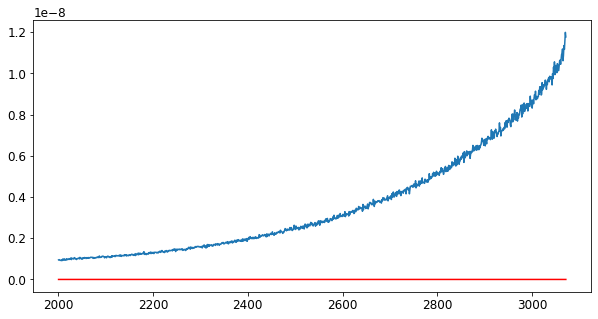

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 939
         Function evaluations: 1707
[ 4.47399538e-03  1.33080361e-03 -1.64165962e+07] 5.012717232885649e-16


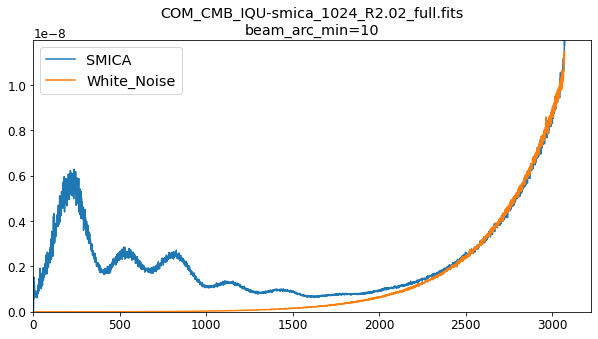

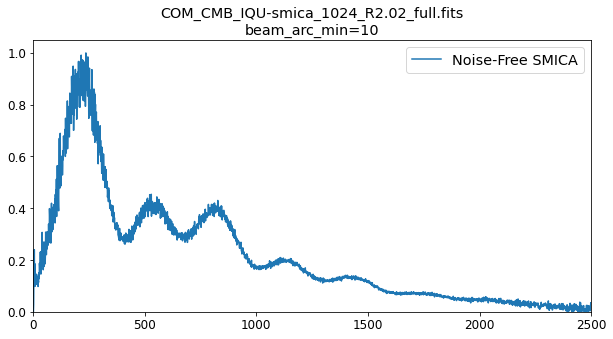

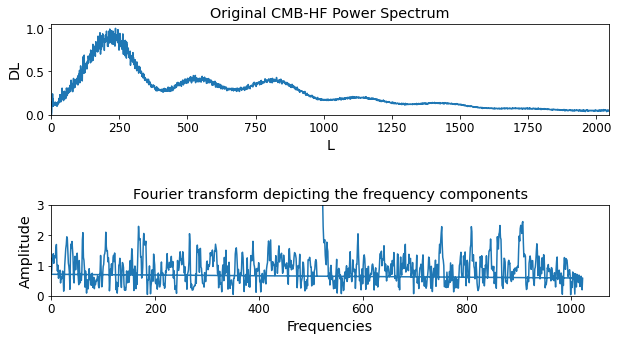

In [2]:
import matplotlib.pylab as plt
import healpy as hp
import numpy as np
import math
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.special import sici, sinc
# import pandas as pd
import terality as pd
from astropy.convolution import convolve, Gaussian1DKernel
from lib4 import *
from scipy.optimize import curve_fit


beam_arc_min=10
beam_arc_noise=1
thishome = "/home/mp74207/Dropbox/GitHub/AAA_CMB_HU/DataSupernovaLBLgov/"
# https://irsa.ipac.caltech.edu/data/Planck/release_3/all-sky-maps/matrix_bpasscorr.html
# https://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/maps/component-maps/cmb/COM_CMB_IQU-smica_1024_R2.02_full.fits

smicafiles = [
              # "COM_CMB_IQU-nilc_2048_R3.00_full.fits",
#               "COM_CMB_IQU-sevem_2048_R3.01_full.fits",
              # "COM_CMB_IQU-smica_1024_R2.01_full.fits",
              "COM_CMB_IQU-smica_1024_R2.02_full.fits",
              # "COM_CMB_IQU-smica_2048_R3.00_full.fits",
              # "COM_CMB_IQU-smica-nosz_2048_R3.00_full.fits",
              # "LFI_SkyMap_030-BPassCorrected_1024_R3.00_full.fits",
              # "LFI_SkyMap_044-BPassCorrected_1024_R3.00_full.fits",
              # "LFI_SkyMap_070-BPassCorrected_1024_R3.00_full.fits",
              ]



mygauss = fitClass()
for f in smicafiles:
    planck_IQU_SMICA = hp.fitsfunc.read_map(thishome + f, dtype= float)
    if "1024" in f:
        nside=1024
    if "2048" in f:
        nside=2048
        
        
    WNFitRange =2000
    mu_smica, sigma_smica = norm.fit(planck_IQU_SMICA)
    white_noise = np.ma.asarray(np.random.normal(0, sigma_smica, 12 * nside ** 2))
    cl_WHITE_NOISE, dll_WHITE_NOISE, ell = get_dl(white_noise, nside=nside, beam_arc_min=beam_arc_noise)
#     for beam_arc_min in [10]:
    cl_SMICA, dll_SMICA, ell = get_dl(planck_IQU_SMICA, nside=nside, beam_arc_min=beam_arc_min)
    mygauss.smica=dll_SMICA[ell>WNFitRange]
    mygauss.t = ell[ell>WNFitRange]
    mygauss.white_noise = dll_WHITE_NOISE[ell > WNFitRange]
    x0 = np.array([ 0,  1.02461539e-2, -1.00693933e-03])
    mygauss.plotme(x0)
    mygauss.func=mygauss.correctWN
    xout, err = mygauss.optimizeme(x0)
    print(xout, err)
    mygauss.smica=dll_SMICA
    mygauss.t = ell
    mygauss.white_noise = dll_WHITE_NOISE
    adjWN = mygauss.correctWN(xout)
    ymax = np.max(dll_SMICA)
    plt.plot(ell, dll_SMICA, ell, adjWN)
    plt.legend([ "SMICA", "White_Noise"])
    plt.ylim([0,ymax])
    plt.xlim([0,None])
    plt.title(f + "\n"+ "beam_arc_min={}".format(beam_arc_min))
    plt.show()
    dll_SMICA_Clean_NoNoise = np.abs(dll_SMICA-adjWN)
    dll_SMICA_Clean_NoNoise /= np.max(dll_SMICA_Clean_NoNoise[0:500])
    plt.plot(ell, dll_SMICA_Clean_NoNoise)
    plt.legend([ "Noise-Free SMICA"])
    plt.ylim([0,None])
    plt.xlim([0,2500])
    plt.title(f + "\n"+ "beam_arc_min={}".format(beam_arc_min))
    plt.show()


    samplingFrequency=2048
    # Laplace transform (t->s)
    y = dll_SMICA_Clean_NoNoise[1:samplingFrequency]
    t = ell[1:samplingFrequency]
    y[y <= 0] = 0.0
    # Frequency domain representation
   
    # Create subplot
    figure, axis = plt.subplots(2, 1)
    plt.subplots_adjust(hspace=1)

    # Time domain representation for sine wave 1
    axis[0].set_title('Original CMB-HF Power Spectrum')
    axis[0].plot(t, y)
    axis[0].set_xlim([0,samplingFrequency])
    axis[0].set_ylim([0, None])
    axis[0].set_xlabel('L')
    axis[0].set_ylabel('DL')
    # plt.show()
    # Time domain representation for sine wave 2
    fourierTransform = np.fft.fft(y)   # Normalize amplitude
    fourierTransform = fourierTransform[range(int(len(y) / 2))]  # Exclude sampling frequency
    tpCount = len(y)
    values = np.arange(int(tpCount / 2))
    timePeriod = tpCount / samplingFrequency
    frequencies = np.fft.fftshift(values / timePeriod)
    periods = 1/frequencies
    # Frequency domain representation
    axis[1].set_title('Fourier transform depicting the frequency components')
    axis[1].plot(frequencies, abs(fourierTransform))
    axis[1].set_xlabel('Frequencies')
    axis[1].set_ylabel('Amplitude')
    axis[1].set_xlim(0,None)
    axis[1].set_ylim(0, 3)
    plt.show()
    a=1


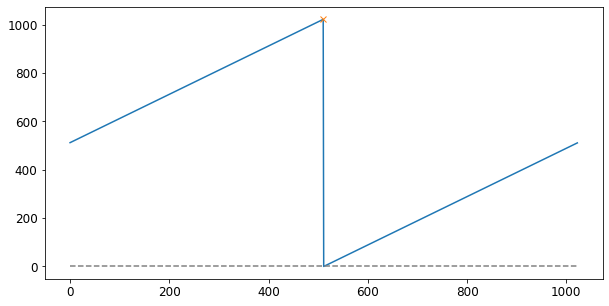

In [3]:
from scipy.signal import find_peaks
x = frequencies
peaks, _ = find_peaks(x, height=1)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [4]:
x[peaks], peaks

(array([1022.49926722]), array([510]))

[ 4.47399538e-03  1.33080361e-03 -1.64165962e+07] 3.199152034431036e+20


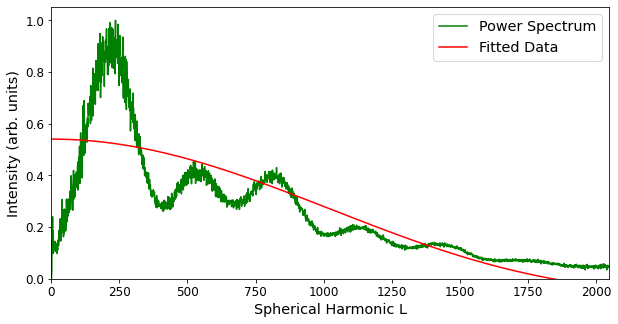

(array([1.62167744e+00, 2.57427032e+03]), 3.199152034431036e+20)

In [5]:
# mygauss.six_peaks



ix=0
fx=2500



samplingFrequency=2048   
mygauss.n = 2
mygauss.smica=dll_SMICA_Clean_NoNoise[1:samplingFrequency]
mygauss.t = ell[1:samplingFrequency]
mygauss.func = mygauss.ffitme
x0=np.array([0.77286083, 500])
popt, err = mygauss.optimizeme(x0)
print(xout, err)
# # print("[", *popt, "]" , sep=", ")
# parguess = np.array(popt).reshape([mygauss.n, 4])
# print(repr(parguess))
# parguess = parguess[parguess[:, 1].argsort()]
# centers = np.array([parguess[x, 1] for x in np.arange(mygauss.n)])
# freqs = centers[1::] - centers[0:-1:]
# amplt = np.array([parguess[x, 0]* np.exp(-parguess[x, 3] * parguess[x, 0]) for x in np.arange(mygauss.n)])
# fitting1 = np.polyfit(centers, np.log(amplt), 1)
# yy = np.exp(fitting1[1]) * np.exp(fitting1[0] * ell)
# # First peak is at pi/2=l*Delta => Delta=pi/2/l
# delta = np.pi / 2 / centers[0]
# gamma1 = fitting1[0] / delta

################################################################
################################################################
x0=np.array([10, 316.45668984])
fig, axis1 = plt.subplots()
axis1.plot(mygauss.t, mygauss.smica, color="green")
axis1.plot(mygauss.t, mygauss.func(popt), 'r-')
axis1.set_xlim([0, samplingFrequency])
axis1.set_ylim([0, None])
axis1.set_xlabel('Spherical Harmonic L')
axis1.set_ylabel('Intensity (arb. units)')
# axis1.set_title("Dissipation on High-Fequency CMB Power Spectrum \n delta ={}  Gamma={}".format('%.4E', '%.4E') %
#           (delta, gamma1))
plt.legend(['Power Spectrum', 'Fitted Data'])
plt.savefig('./img1/HighFreqFittedPowerSpectrum.png')
plt.show()

popt,err

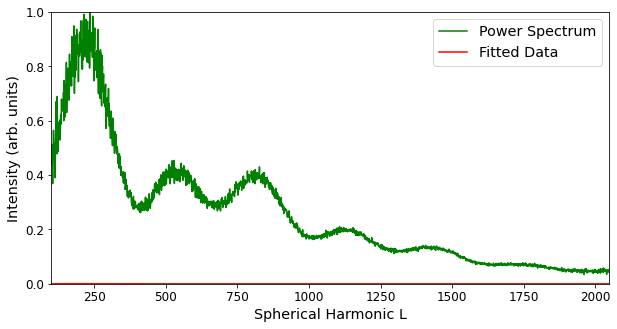

In [6]:
from scipy.special import spherical_jn
spherical_jn(0, 3+5j)

def ffitme(t,x0):
    a=x0[0]
    R=x0[1]
    alpha = x0[2]
    xx = 2*np.pi*t/R
    return np.abs(a*(xx*R)**alpha*(spherical_jn(0, xx)-xx*spherical_jn(1, xx))/xx**3)**2

x0=np.array([2e-1, 410, 0.1])
fig, axis1 = plt.subplots()
axis1.plot(mygauss.t, mygauss.smica, color="green")
axis1.plot(mygauss.t, ffitme(mygauss.t, x0), 'r-')
axis1.set_xlim([0, samplingFrequency])
axis1.set_xlim([100, 2048])
axis1.set_ylim([0, 1])
# axis1.set_xscale("log")
axis1.set_xlabel('Spherical Harmonic L')
axis1.set_ylabel('Intensity (arb. units)')
# axis1.set_title("Dissipation on High-Fequency CMB Power Spectrum \n delta ={}  Gamma={}".format('%.4E', '%.4E') %
#           (delta, gamma1))
plt.legend(['Power Spectrum', 'Fitted Data'])
plt.savefig('./img1/HighFreqFittedPowerSpectrum.png')
plt.show()

array([[ 5.70205573e+00,  6.94537244e+01,  7.16979664e+01,
        -1.25106172e-03],
       [ 1.74760036e+01,  1.56882899e+02,  9.07915514e+01,
        -8.00483674e-03],
       [ 1.08583319e+01,  5.10830640e+02,  9.41055921e+01,
        -2.35793613e-03],
       [ 5.58673026e+00,  7.88793117e+02,  1.02188173e+02,
        -2.37637964e-03],
       [ 5.34414953e+00,  1.11917667e+03,  9.95714693e+01,
        -8.68909472e-04],
       [ 3.41211218e+00,  1.41773588e+03,  8.40577463e+01,
        -3.03418704e-04],
       [ 8.85641726e+00,  1.27521274e+03,  5.02999379e+02,
        -1.00840344e-03]])


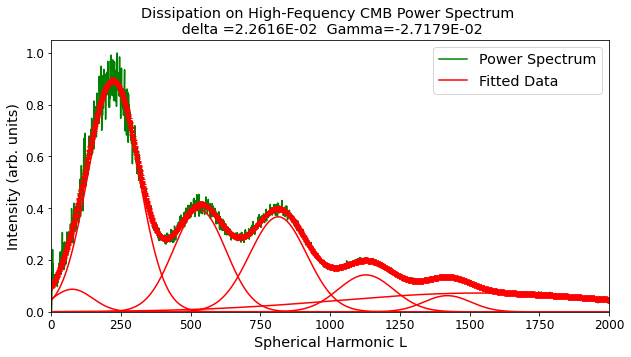

In [31]:
# mygauss.six_peaks

mygauss.n = 7
# parguess = np.array([
#                 [ 5.53854157e+00,  7.00266435e+01,  7.00777096e+01, -4.71809806e-04],
#                 [ 1.77361599e+01,  1.55567356e+02,  9.12718640e+01, -8.02223961e-03],
#                 [ 1.09918918e+01,  5.10673410e+02,  9.44176854e+01, -2.38082978e-03],
#                 [ 5.83153742e+00,  7.88332693e+02,  1.04239503e+02, -2.42467574e-03],
#                 [ 6.39456388e+00,  1.11768910e+03,  1.07729774e+02, -1.00123907e-03],
#                 [ 4.29089695e+00,  1.41126485e+03,  9.27114473e+01, -4.34658095e-04],
#                 [ 5.37229780e+00,  1.62312591e+03,  2.90255845e+02,-7.87717500e-04]
#             ])

parguess = np.array([
                 5.53854157e+00,  7.00266435e+01,  7.00777096e+01, -4.71809806e-04,
                 1.77361599e+01,  1.55567356e+02,  9.12718640e+01, -8.02223961e-03,
                 1.09918918e+01,  5.10673410e+02,  9.44176854e+01, -2.38082978e-03,
                 5.83153742e+00,  7.88332693e+02,  1.04239503e+02, -2.42467574e-03,
                 6.39456388e+00,  1.11768910e+03,  1.07729774e+02, -1.00123907e-03,
                 4.29089695e+00,  1.41126485e+03,  9.27114473e+01, -4.34658095e-04,
                 5.37229780e+00,  1.62312591e+03,  2.90255845e+02,-7.87717500e-04,
            ])

ix=0
fx=2500
popt, err = curve_fit(mygauss.six_peaks, ell[ix:fx], dll_SMICA_Clean_NoNoise[ix:fx], parguess)
# print("[", *popt, "]" , sep=", ")
parguess = np.array(popt).reshape([mygauss.n, 4])
print(repr(parguess))
parguess = parguess[parguess[:, 1].argsort()]
centers = np.array([parguess[x, 1] for x in np.arange(mygauss.n)])
freqs = centers[1::] - centers[0:-1:]
amplt = np.array([parguess[x, 0]* np.exp(-parguess[x, 3] * parguess[x, 0]) for x in np.arange(mygauss.n)])
fitting1 = np.polyfit(centers, np.log(amplt), 1)
yy = np.exp(fitting1[1]) * np.exp(fitting1[0] * ell)
# First peak is at pi/2=l*Delta => Delta=pi/2/l
delta = np.pi / 2 / centers[0]
gamma1 = fitting1[0] / delta

################################################################
################################################################
fig, axis1 = plt.subplots()
axis1.plot(ell, dll_SMICA_Clean_NoNoise, color="green")
for i in np.arange(mygauss.n):
    axis1.plot(ell, mygauss.fitfun(ell, *parguess[i, :]), 'r-')
axis1.plot(ell, mygauss.six_peaks(ell, *popt), 'r+')
axis1.set_xlim([0, 2000])
axis1.set_ylim([0, None])
axis1.set_xlabel('Spherical Harmonic L')
axis1.set_ylabel('Intensity (arb. units)')
axis1.set_title("Dissipation on High-Fequency CMB Power Spectrum \n delta ={}  Gamma={}".format('%.4E', '%.4E') %
          (delta, gamma1))
plt.legend(['Power Spectrum', 'Fitted Data'])
plt.savefig('./img1/HighFreqFittedPowerSpectrum.png')
plt.show()



array([2.85290966e+02, 2.30560538e+02, 9.51827531e+01, 3.09384468e+02,
       1.66389900e-03, 2.52694698e-02])


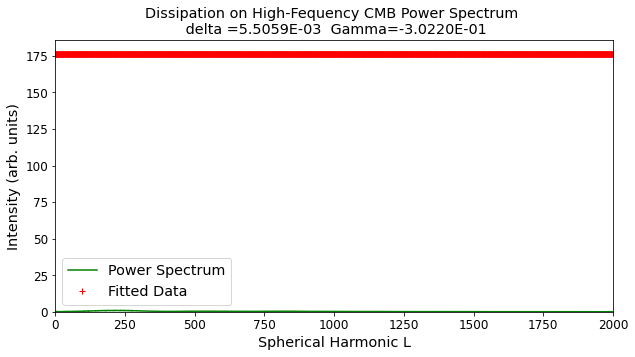

In [8]:
# mygauss.seven_peaks

mygauss.n = 7

# a0 = parkguess[0]  # first peak height
# a1 = parkguess[1]  # Gaussian Center
# a2 = parkguess[2]  # std of gaussian
# deltaL = parkguess[3] # shift in L
# gamma = parkguess[4]  # exponential rate of peak decay
# baseline = parkguess[5]

parguess = np.array([350,  220,  100, 310, 0.0016,-0.022 ])

ix=0
fx=2500
parguess, err = curve_fit(mygauss.seven_peaks, ell[ix:fx], dll_SMICA_Clean_NoNoise[ix:fx], parguess)
print(repr(parguess))
######################################################
a0 = parguess[0]  # first peak height
a1 = parguess[1]  # Gaussian Center
a2 = parguess[2]  # std of gaussian
deltaL = parguess[3] # shift in L
gamma = parguess[4]  # exponential rate of peak decay
baseline = parguess[5]
######################################################
centers = np.array([ a0 + deltaL * i for i in np.arange(mygauss.n)])
freqs = centers[1::] - centers[0:-1:]
amplt = np.array([a0* np.exp(-gamma *centers[i] ) for i in np.arange(mygauss.n)])
fitting1 = np.polyfit(centers, np.log(amplt), 1)
yy = np.exp(fitting1[1]) * np.exp(fitting1[0] * ell)
# First peak is at pi/2=l*Delta => Delta=pi/2/l
delta = np.pi / 2 / centers[0]
gamma1 = fitting1[0] / delta

################################################################
################################################################
fig, axis1 = plt.subplots()
axis1.plot(ell, dll_SMICA_Clean_NoNoise, color="green")
# for i in np.arange(mygauss.n):
#     axis1.plot(ell, mygauss.fitfun(ell, *parguess[i, :]), 'r-')
axis1.plot(ell, mygauss.seven_peaks(ell, *popt), 'r+')
axis1.set_xlim([0, 2000])
axis1.set_ylim([0, None])
axis1.set_xlabel('Spherical Harmonic L')
axis1.set_ylabel('Intensity (arb. units)')
axis1.set_title("Dissipation on High-Fequency CMB Power Spectrum \n delta ={}  Gamma={}".format('%.4E', '%.4E') %
          (delta, gamma1))
plt.legend(['Power Spectrum', 'Fitted Data'])
plt.savefig('./img1/HighFreqFittedPowerSpectrum.png')
plt.show()



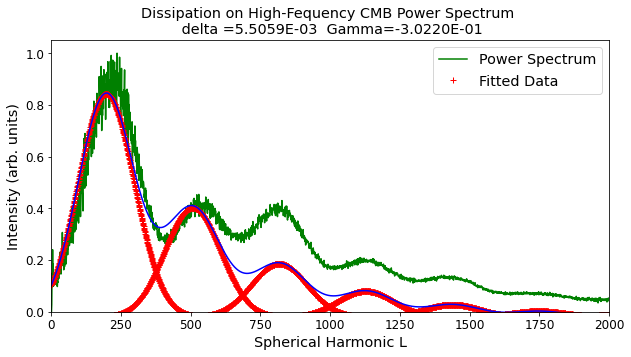

In [9]:
parguess = np.array([350,  220,  100, 310, 0.0023,-0.022 ])
######################################################
a0 = parguess[0]  # first peak height
a1 = parguess[1]  # Gaussian Center
a2 = parguess[2]  # std of gaussian
deltaL = parguess[3] # shift in L
gamma = parguess[4]  # exponential rate of peak decay
baseline = parguess[5]
######################################################
fig, axis1 = plt.subplots()
axis1.plot(ell, dll_SMICA_Clean_NoNoise, color="green")
p=np.zeros([1, len(ell)])
for i in np.arange(mygauss.n):
    p *=0.0
    p =  a0 * norm.pdf(ell, loc=a1+ deltaL*i, scale=a2) 
    p = p * np.exp(-gamma *ell) + baseline
    axis1.plot(ell, p.squeeze(), 'r+')
axis1.plot(ell, mygauss.seven_peaks(ell, *parguess), 'b-')
axis1.set_xlim([0, 2000])
axis1.set_ylim([0, None])
axis1.set_xlabel('Spherical Harmonic L')
axis1.set_ylabel('Intensity (arb. units)')
axis1.set_title("Dissipation on High-Fequency CMB Power Spectrum \n delta ={}  Gamma={}".format('%.4E', '%.4E') %
          (delta, gamma1))
plt.legend(['Power Spectrum', 'Fitted Data'])
plt.savefig('./img1/HighFreqFittedPowerSpectrum.png')
plt.show()

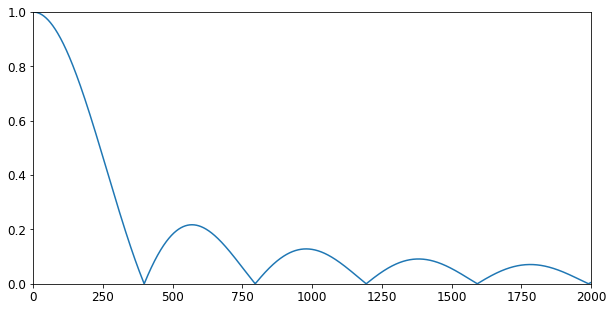

In [10]:
T=2500
omega=2*np.pi/T 
x1 = np.linspace(0,2000,2000)
y1=np.abs(np.sinc(omega*x1))
plt.plot(x1,y1)
plt.ylim(0,1.0)
plt.xlim(0,2000)
plt.show()

In [11]:
popt[-1:]

array([-0.00078772])

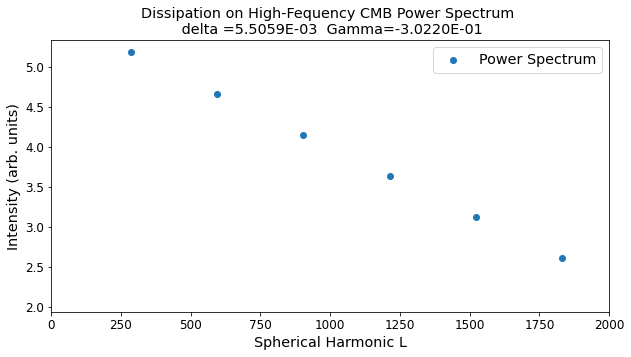

In [12]:
#Plot Amplitudes and centers

# First peak is at pi/2=l*Delta => Delta=pi/2/l



fig, axis1 = plt.subplots()
fitting1 = np.polyfit(centers, np.log(amplt), 1)
yy = fitting1[0] * np.exp(np.exp( fitting1[1]) * ell)
# First peak is at pi/2=l*Delta => Delta=pi/2/l
plt.scatter(centers, np.log(amplt))  # THIS IS WHAT i AM PLOTTING 
# plt.plot(ell, yy)
plt.xlim([0, 2000])
# plt.ylim([-200, 2000])
plt.xlabel('Spherical Harmonic L')
plt.ylabel('Intensity (arb. units)')
plt.title("Dissipation on High-Fequency CMB Power Spectrum \n delta ={}  Gamma={}".format('%.4E', '%.4E') % (
    delta, gamma1))
plt.legend(['Power Spectrum', 'Fitted Data'])
# plt.savefig('./img1/HighFreqDissipationFittedPowerSpectrum.png')
plt.show()

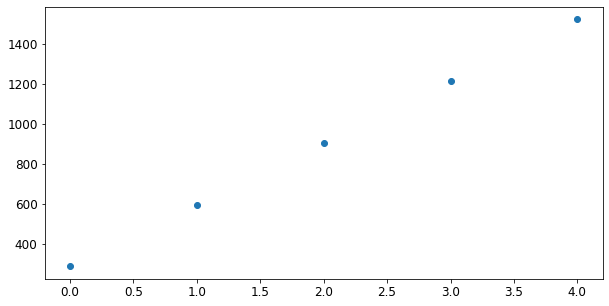

array([ 285.29096559,  594.67543371,  904.05990182, 1213.44436994,
       1522.82883805, 1832.21330617, 2141.59777428])

In [13]:
centers = np.sort(centers)
y=centers[0:5]
plt.scatter(x=np.arange(len(y)),y=y  )
plt.show()
centers

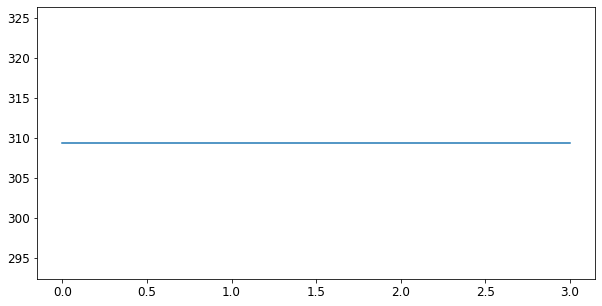

In [14]:

plt.plot(freqs[0:4])
plt.show()

[[Model]]
    ((((((Model(gaussian, prefix='f0_') + Model(gaussian, prefix='f1_')) + Model(gaussian, prefix='f2_')) + Model(gaussian, prefix='f3_')) + Model(gaussian, prefix='f4_')) + Model(gaussian, prefix='f5_')) + Model(gaussian, prefix='f6_'))
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 4092
    # data points      = 2000
    # variables        = 21
    chi-square         = 222.461098
    reduced chi-square = 0.11241086
    Akaike info crit   = -4350.30042
    Bayesian info crit = -4232.68147
##  Warning: uncertainties could not be estimated:
    f0_center:     at initial value
    f1_center:     at initial value
    f2_center:     at initial value
    f2_sigma:      at boundary
    f3_center:     at initial value
    f4_center:     at initial value
    f5_center:     at initial value
    f6_center:     at initial value
[[Variables]]
    f0_amplitude:  481.037546 (init = 177.4722)
    f0_center:     285.290030 (init = 285.291)
    f0_sigma:      

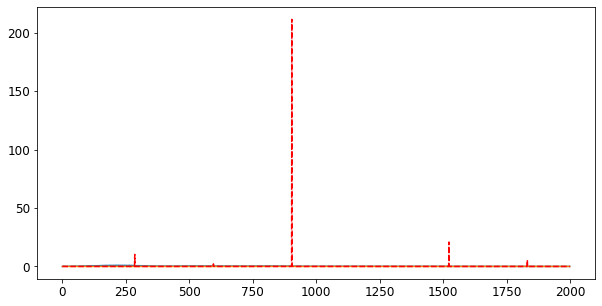

In [15]:
from lmfit.models import LorentzianModel, ConstantModel, GaussianModel
import numpy as np
import matplotlib.pyplot as plt

x=ell[0:2000]
y=dll_SMICA_Clean_NoNoise[0:2000]


peaks_in_interval = centers
number_of_peaks = len(peaks_in_interval)
amplitude = amplt
width = np.zeros(number_of_peaks) + 0.1
center = centers

def make_model(num):
    pref = "f{0}_".format(num)
#     model = LorentzianModel(prefix = pref)
    model = GaussianModel(prefix = pref)
    model.set_param_hint(pref+'amplitude', value=amplitude[num], min=0, max=5*amplitude[num])
    model.set_param_hint(pref+'center', value=center[num], min=center[num]-0.5, max=center[num]+0.5)
    model.set_param_hint(pref+'sigma', value=width[num], min=0, max=2)
    return model

mod = None
for i in range(len(peaks_in_interval)):
    this_mod = make_model(i)
    if mod is None:
        mod = this_mod
    else:
        mod = mod + this_mod

# offset = ConstantModel()
# offset.set_param_hint('c', value=np.average(y[-75:]))
# mod = mod + offset

out=mod.fit(y, x=x, method='nelder')
plt.interactive(True)
print(out.fit_report())
plt.plot(x, y)
plt.plot(x, out.best_fit, label='best fit')
plt.plot(x, out.init_fit, 'r--', label='fit with initial values')
plt.show()

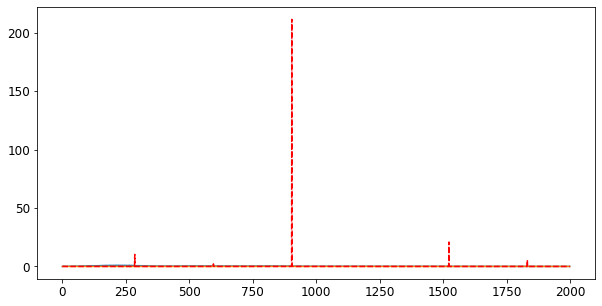

In [16]:
plt.plot(x, y)
plt.plot(x, out.best_fit, label='best fit')
plt.plot(x, out.init_fit, 'r--', label='fit with initial values')
plt.show()

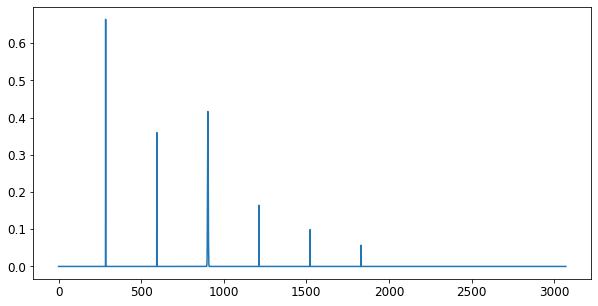

In [17]:
plt.plot(ell, mod.eval(out.params, x=ell) )
# plt.yscale("log")
plt.show()

In [18]:
out.params

name,value,initial value,min,max,vary,expression
f0_amplitude,481.037546,177.47224629813113,0.00000000,887.361231,True,
f0_center,285.290030,285.29096559315354,284.790966,285.790966,True,
f0_sigma,0.07114497,0.1,0.00000000,2.00000000,True,
f1_amplitude,115.247042,106.06262583110755,0.00000000,530.313129,True,
f1_center,594.673989,594.675433708001,594.175434,595.175434,True,
f1_sigma,0.08524813,0.1,0.00000000,2.00000000,True,
f2_amplitude,2.08857854,63.38613970824564,0.00000000,316.930699,True,
f2_center,904.061758,904.0599018228486,903.559902,904.559902,True,
f2_sigma,1.99999848,0.1,0.00000000,2.00000000,True,
f3_amplitude,32.5186771,37.881418413222406,0.00000000,189.407092,True,


[[Model]]
    ((Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_')) + Model(exponential, prefix='exp_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 18000
    # data points      = 2000
    # variables        = 8
    chi-square         = 35.5252670
    reduced chi-square = 0.01783397
    Akaike info crit   = -8045.31654
    Bayesian info crit = -8000.50932
##  Warning: uncertainties could not be estimated:
    g1_amplitude:   at boundary
[[Variables]]
    exp_amplitude:  0.53141221 (init = 0.610892)
    exp_decay:      1149.45335 (init = 847.0298)
    g1_amplitude:   10.0000406 (init = 2000)
    g1_center:      109.601563 (init = 105)
    g1_sigma:       9.56015940 (init = 15)
    g1_fwhm:        22.5124546 == '2.3548200*g1_sigma'
    g1_height:      0.41729840 == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_amplitude:   20.3187783 (init = 2000)
    g2_center:      161.504215 (init = 155)
    g2_sigma:       22.1275457 (init = 15)
    

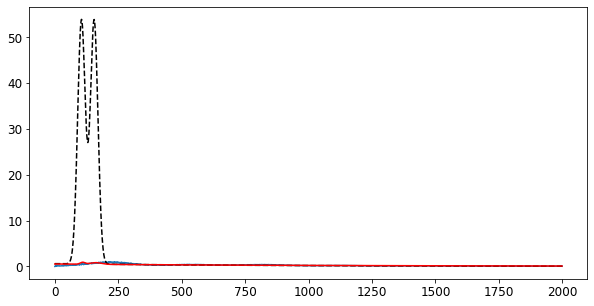

In [19]:
import numpy as np
from lmfit.models import GaussianModel, ExponentialModel
import sys
import matplotlib.pyplot as plt

dat = np.loadtxt('./NIST_Gauss2.dat')
# x = dat[:, 1]
# y = dat[:, 0]

exp_mod = ExponentialModel(prefix='exp_')
pars = exp_mod.guess(y, x=x)

gauss1  = GaussianModel(prefix='g1_')
pars.update( gauss1.make_params())

pars['g1_center'].set(105, min=75, max=125)
pars['g1_sigma'].set(15, min=3)
pars['g1_amplitude'].set(2000, min=10)

gauss2  = GaussianModel(prefix='g2_')

pars.update(gauss2.make_params())

pars['g2_center'].set(155, min=125, max=175)
pars['g2_sigma'].set(15, min=3)
pars['g2_amplitude'].set(2000, min=10)

mod = gauss1 + gauss2 + exp_mod


init = mod.eval(pars, x=x)
plt.plot(x, y)
plt.plot(x, init, 'k--')

out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.5))

plt.plot(x, out.best_fit, 'r-')
plt.show()

## import cmath 
def A(l,L,alpha, beta,sigma):
    xx = np.arange(-l.max(),l.max())
    n=len(xx)
    gauss = norm.pdf(xx, loc=0.0, scale=sigma)
    i = 1.J
    l=l*np.pi
    a1 = 1/np.sqrt(2*np.pi)/((np.log(2)/L)-i*l)*(np.exp(((np.log(2)/L)-i*l)*L)-1)
    a2 = np.sqrt(2/pi)*(2/L)*np.exp(-i*l*L/2)*np.sin(l*L/2)/(l*L/2)
    amplitude = a1-a2
    amplitude_conv = np.convolve(amplitude, gauss)
    return np.abs(amplitude_conv[1999:])**2*xx**alpha*np.exp(-beta*xx)

l = np.arange(2000)
L=1/200
beta=1/1600
alpha= 2.3 #2000*beta
power = A(l,L,alpha, beta,2000)
plt.plot(l,power[1999:])
plt.show()

In [20]:
np.convolve([1, 2, 3], [0, 1, 0.5])
norm.pdf(x, loc=a1+ deltaL*i, scale=a2)

array([4.51157042e-97, 5.55442719e-97, 6.83765818e-97, ...,
       2.82694482e-03, 2.85036358e-03, 2.87368897e-03])

Optimization terminated successfully.
         Current function value: 202.868852
         Iterations: 163
         Function evaluations: 383


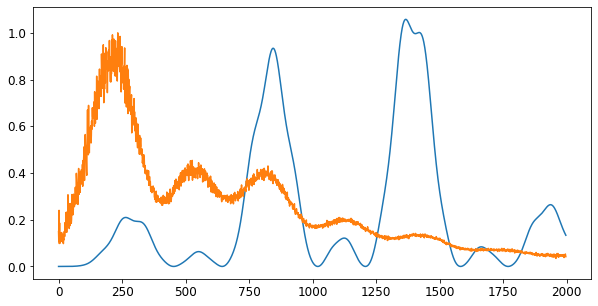

L= 0.0035714285714285713
H= 0.01
beta= -0.000408178323
sigma= 19.857089


In [21]:
import cmath 
####################################################
n_coeff =4
n_len = 2000
l= np.expand_dims(np.arange(n_len), axis=0)
ln= np.expand_dims(np.arange(n_coeff), axis=1)

n1=1
x_array = np.power(l,ln)[:,1:]
y_smica =dll_SMICA_Clean_NoNoise[(n1+1):2000]
y_smica /= np.nanmax(y_smica)

half =int(n_len/2)
xx = np.arange(-half,half)

def x_array_mult(x1,n1):
    xxx1=np.array(x1)
    xxx2 = np.expand_dims(xxx1, axis=1)
    return np.sum(xxx2* x_array[:,n1::], axis=0)


def A(x,L,beta,n1, sigma, H ,x10):
#     print(len(x10))
#     print(beta)
    x1=x10[0:len(x10)//2]
    x2=x10[len(x10)//2:]
    gauss = norm.pdf(xx, loc=0.0, scale=sigma)
    i = 1.J
    l=x*np.pi
    a1 = 1/np.sqrt(2*np.pi)/((np.log(2)/L)-i*l)*(np.exp(((np.log(2)/L)-i*l)*L)-1)
    a2 = np.sqrt(2/pi)*(2*L)*np.exp(-i*l/2/L)*np.sin(l/2/L )/(l/L/2)
    a1 = a1/np.max(a1[1:])
    a2 = a2/np.max(a2[1:])
    amplitude = np.imag((x_array_mult(x1,n1)*a1+x_array_mult(x2,n1)*a2)*np.exp(-beta*l))*np.exp(i*l*H)
    power_real = np.real(amplitude)**2*l
    power_imag = np.imag(amplitude)**2*l
    power_real = power_real/np.max(power_real[1:])
    power_imag = power_imag/np.max(power_imag[1:])
    return power_imag + power_real

#     power_real_convoluted = np.convolve(power_real,gauss)
#     power_imag_convoluted = np.convolve(power_imag,gauss)
#     return power_real_convoluted + power_imag_convoluted



def errff(x0,L,n1):
    x = x_array[1,:]
    sigma=x0[-1]
    beta = x0[-2]
    H = x0[-3]
    x10 = x0[0:-3:]
    x=x_array[1,n1::]
    power = A(x,L,beta,n1, H, sigma,x10)
    err = np.nansum( (y_smica-power)**2 )
    return err
    
    
    


L=1/280


x0=(0,1,0,0,  0,1,0,0, 0.001, 10)
x0 = np.array([ 9.54490567e-04,  9.60696423e-01, -7.81852664e-04,  1.57335162e-07,
        3.13055943e-03,  1.23079916e+00, -1.40903458e-03,  4.22913796e-07, 1e-2,
       -4.08178323e-04,  1.98570890e+01])


x0out = minimize(errff, x0, method='nelder-mead',args=(L,n1), options={'xatol': 1e-6, 'disp': True})

sigma = x0out.x[0]
x10 = x0out.x[1::]

    
# y = A(x_array[1,:],L,sigma, x10)
# plt.plot(y)
# plt.plot(dll_SMICA_Clean_NoNoise[0:2000])
# # plt.plot(gauss1)
# # plt.plot(gauss)
# # plt.yscale("log")
# # yy = np.convolve(gauss, gauss)
# # plt.plot(xx,yy[n:3*n])
# # plt.plot(xx, gauss, color="r")
# plt.title("".format(x0out.fun))
# plt.show()
# x0out.x,
x0out

n1=1
y_smica =dll_SMICA_Clean_NoNoise[(n1+1):2000]
y_smica /= np.nanmax(y_smica)
sigma = x0[-1]
beta=x0[-2]
H =x0[-3]
x10 = x0[0:-3:]
y = A(x_array[1,n1::],L,beta,n1, sigma, H,x10)
plt.plot(y[n1:2000])
plt.plot(y_smica[n1:2000])
        
plt.show() 
print("L=", L)
print("H=", H)
print("beta=", beta)
print("sigma=", sigma)


In [22]:
import cmath 
####################################################
n_coeff =4
n_len = 2000
l= np.expand_dims(np.arange(n_len), axis=0)
ln= np.expand_dims(np.arange(n_coeff), axis=1)

n1=1
x_array = np.power(l,ln)[:,1:]
y_smica =dll_SMICA_Clean_NoNoise[(n1+1):2000]
y_smica /= np.nanmax(y_smica)

half =int(n_len/2)
xx = np.arange(-half,half)

def x_array_mult(x1,n1):
    xxx1=np.array(x1)
    xxx2 = np.expand_dims(xxx1, axis=1)
    return np.sum(xxx2* x_array[:,n1::], axis=0)


def A(x,L,beta,n1, sigma, H ):
    i = 1.J
    l=x*np.pi
    a1 = 1/np.sqrt(2*np.pi)/((np.log(2)/L)-i*l)*(np.exp(((np.log(2)/L)-i*l)*L)-1)
    a2 = np.sqrt(2/pi)*(2*L)*np.exp(-i*l/2/L)*np.sin(l/2/L )/(l/L/2)
    amplitude = np.imag((a1+a2)*np.exp(-beta*l))*np.exp(i*l*H)
    power_real = np.real(amplitude)**2*l
    power_imag = np.imag(amplitude)**2*l
    power_real = power_real/np.max(power_real[1:])
    power_imag = power_imag/np.max(power_imag[1:])
    return power_imag + power_real

#     power_real_convoluted = np.convolve(power_real,gauss)
#     power_imag_convoluted = np.convolve(power_imag,gauss)
#     return power_real_convoluted + power_imag_convoluted



def errff(x0,L,n1):
    x = x_array[1,:]
    sigma=x0[-1]
    beta = x0[-2]
    H = x0[-3]
    x=x_array[1,n1::]
    power = A(x,L,beta,n1, H, sigma)
    err = np.nansum( (y_smica-power)**2 )
    return err
    
    
    


L=1/280

x0 = np.array([ 4.22913796e-07, 1e-2, -4.08178323e-04,  1.98570890e+01])


x0out = minimize(errff, x0, method='nelder-mead',args=(L,n1), options={'xatol': 1e-6, 'disp': True})

sigma = x0out.x[0]
x10 = x0out.x[1::]

x0out

n1=1
y_smica =dll_SMICA_Clean_NoNoise[(n1+1):2000]
y_smica /= np.nanmax(y_smica)
sigma = x0[-1]
beta=x0[-2]
H =x0[-3]
x10 = x0[0:-3:]
y = A(x_array[1,n1::],L,beta,n1, sigma, H,x10)
plt.plot(y[n1:2000])
plt.plot(y_smica[n1:2000])
        
plt.show() 
print("L=", L)
print("H=", H)
print("beta=", beta)
print("sigma=", sigma)


Optimization terminated successfully.
         Current function value: 53.348792
         Iterations: 126
         Function evaluations: 251


TypeError: A() takes 6 positional arguments but 7 were given

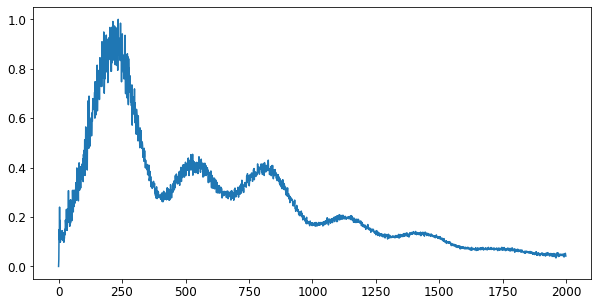

In [23]:
plt.plot(dll_SMICA_Clean_NoNoise[n1:2000])
plt.show()

In [24]:
x0out.x

array([ 4.64736462e-07,  1.07300194e-02, -1.19939762e-05,  3.07875520e+01])

In [25]:
L=220
x0=np.array([ 9.83791380e-04,  9.30218420e-01, -8.11391553e-04,  1.55081828e-07,
        2.98283004e-03,  1.22135062e+00, -1.44553170e-03,  4.24011461e-07,
        1.00998051e-02, -4.02041871e-04,  2.05270203e+01])
sigma = x0[-1]
beta=x0[-2]
H =x0[-3]
x10 = x0[0:-3:]

sigma = x0[-1]
beta=x0[-2]
H =x0[-3]
x10 = x0[0:-3:]

x10 = np.array([0,1,0,0,
                0,1,0,0,0])
y = A(x_array[1,n1::],L,beta,n1, sigma, H,x10)
plt.plot(y[n1:2000])
plt.plot(y_smica[n1:2000])



y = A(x_array[1,n1::],L,beta,n1, sigma, H,x10)
plt.plot(y[n1:2000])
plt.plot(y_smica[n1:2000])
plt.plot(y[n1:2000])
plt.plot(y_smica[n1:2000])
        
plt.show()  

TypeError: A() takes 6 positional arguments but 7 were given

In [26]:
(alpha, beta,delta, a,b, c) = x0out.x
L=1/270
alpha = 0.9
# beta=3.9e-05
# c=1e2
# alpha= -0.1
# # # alpha= 1.1
# # # delta =0
# # a, b= -3.14744824e+00/2,  1.59091518e+03/4

# # a=0.5
# # b=0.5

for a in np.linspace(570,800,10):
    for b in np.linspace(1400,1800,10):
        for LL in [270]:
            y = A(l,1/LL,alpha, beta,delta, a,b,c)
            y = y[400:2000]
            y = y/np.max(y)
            plt.plot(y)
plt.plot(y_smica)
  
# y = A(l,L,alpha, beta,delta, a,b,c)

# plt.plot(y[400:2000])

# plt.plot(y_smica[400:2000])
        
plt.show()  
#         plt.title({}.format(errff(x0))    

ValueError: not enough values to unpack (expected 6, got 4)

In [27]:
L,alpha, beta,delta, a,b

NameError: name 'b' is not defined

In [28]:
1/0.0008479627954817394


1179.2970226151092